In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Input, Dense, Flatten, Conv2D, MaxPooling2D, BatchNormalization, Dropout, Reshape, Concatenate, LeakyReLU
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model

In [2]:
# Height and width refer to the size of the image
# Channels refers to the amount of color channels (red, green, blue)

image_dimensions = {'height':256, 'width':256, 'channels':3}

In [3]:
# Create a Classifier class

class Classifier:
    def __init__():
        self.model = 0
    
    def predict(self, x):
        return self.model.predict(x)
    
    def fit(self, x, y):
        return self.model.train_on_batch(x, y)
    
    def get_accuracy(self, x, y):
        return self.model.test_on_batch(x, y)
    
    def load(self, path):
        self.model.load_weights(path)

In [4]:
# Create a MesoNet class using the Classifier

class Meso4(Classifier):
    def __init__(self, learning_rate = 0.001):
        self.model = self.init_model()
        optimizer = Adam(lr = learning_rate)
        self.model.compile(optimizer = optimizer,
                           loss = 'mean_squared_error',
                           metrics = ['accuracy'])
    
    def init_model(self): 
        x = Input(shape = (image_dimensions['height'],
                           image_dimensions['width'],
                           image_dimensions['channels']))
        
        x1 = Conv2D(8, (3, 3), padding='same', activation = 'relu')(x)
        x1 = BatchNormalization()(x1)
        x1 = MaxPooling2D(pool_size=(2, 2), padding='same')(x1)
        
        x2 = Conv2D(8, (5, 5), padding='same', activation = 'relu')(x1)
        x2 = BatchNormalization()(x2)
        x2 = MaxPooling2D(pool_size=(2, 2), padding='same')(x2)
        
        x3 = Conv2D(16, (5, 5), padding='same', activation = 'relu')(x2)
        x3 = BatchNormalization()(x3)
        x3 = MaxPooling2D(pool_size=(2, 2), padding='same')(x3)
        
        x4 = Conv2D(16, (5, 5), padding='same', activation = 'relu')(x3)
        x4 = BatchNormalization()(x4)
        x4 = MaxPooling2D(pool_size=(4, 4), padding='same')(x4)
        
        y = Flatten()(x4)
        y = Dropout(0.5)(y)
        y = Dense(16)(y)
        y = LeakyReLU(alpha=0.1)(y)
        y = Dropout(0.5)(y)
        y = Dense(1, activation = 'sigmoid')(y)

        return Model(inputs = x, outputs = y)

In [27]:
# Instantiate a MesoNet model with pretrained weights
meso = Meso4()
# meso.load('./weights/Meso4_DF')
meso.load('./Mesonet/weights/Meso4_F2F.h5')


In [6]:
# Prepare image data

# Rescaling pixel values (between 1 and 255) to a range between 0 and 1
dataGenerator = ImageDataGenerator(rescale=1./255)

# Instantiating generator to feed images through the network
generator = dataGenerator.flow_from_directory(
    './data/',
    target_size=(256, 256),
    batch_size=1,
    class_mode='binary')

Found 7104 images belonging to 2 classes.


In [7]:
# Checking class assignment
generator.class_indices

{'DeepFake': 0, 'Real': 1}

In [8]:
# '.ipynb_checkpoints' is a *hidden* file Jupyter creates for autosaves
# It must be removed for flow_from_directory to work.
!rmdir /s /q c:data\.ipynb_checkpoints

# Equivalent command in Unix (for Mac / Linux users)
# !rm -r /Users/mikhaillenko/mesonet/mesonet/data/.ipynb_checkpoints/

The system cannot find the file specified.


In [9]:
# Recreating generator after removing '.ipynb_checkpoints'
dataGenerator = ImageDataGenerator(rescale=1./255)

generator = dataGenerator.flow_from_directory(
    './data/',
    target_size=(256, 256),
    batch_size=1,
    class_mode='binary')
# Re-checking class assignment after removing it
generator.class_indices

Found 7104 images belonging to 2 classes.


{'DeepFake': 0, 'Real': 1}

In [31]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import load_model
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report





Model Summary:
Model: "model_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 conv2d_32 (Conv2D)          (None, 256, 256, 8)       224       
                                                                 
 batch_normalization_32 (Ba  (None, 256, 256, 8)       32        
 tchNormalization)                                               
                                                                 
 max_pooling2d_32 (MaxPooli  (None, 128, 128, 8)       0         
 ng2D)                                                           
                                                                 
 conv2d_33 (Conv2D)          (None, 128, 128, 8)       1608      
                                                                 
 batch_normalization_33 (Ba  (None, 128, 128

In [63]:
# import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
# from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define paths
data_dir = './data'

# Model Summary to Get Number of Parameters
print("Model Summary:")
meso.model.summary()

# Total number of parameters in the model
num_params = meso.model.count_params()
print(f"Total number of parameters: {num_params}")
print("---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------\n")
# Data Augmentation for Validation Data (only rescaling)
val_datagen = ImageDataGenerator(rescale=1.0/255)
val_generator = val_datagen.flow_from_directory(
    data_dir,
    target_size=(256, 256),  # Update to match the model's expected input size
    batch_size=64,
    class_mode='binary',
    shuffle=False  # Important to not shuffle for correct metric calculations
)

# Model Testing
# Get the true labels and predictions
y_true = []
y_pred = []

for i in range(val_generator.samples // val_generator.batch_size):
    x_batch, y_batch = val_generator.next()
    y_true.extend(y_batch)
    y_pred_prob = meso.model.predict_on_batch(x_batch)
    y_pred.extend(y_pred_prob)

y_true = np.array(y_true)
y_pred = np.array(y_pred)

# Convert Predictions to Binary Labels
y_pred_binary = (y_pred >= 0.5).astype(int)

# Calculate Metrics
accuracy = accuracy_score(y_true, y_pred_binary)
precision = precision_score(y_true, y_pred_binary)
recall = recall_score(y_true, y_pred_binary)
f1 = f1_score(y_true, y_pred_binary)

print("---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------\n")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

# Confusion Matrix and Classification Report
cm = confusion_matrix(y_true, y_pred_binary)
print("---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------\n")
print("Confusion Matrix:")
print(cm)

report = classification_report(y_true, y_pred_binary)
print("---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------\n")
print("Classification Report:")
print(report)


Model Summary:
Model: "model_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_10 (InputLayer)       [(None, 256, 256, 3)]     0         
                                                                 
 conv2d_36 (Conv2D)          (None, 256, 256, 8)       224       
                                                                 
 batch_normalization_36 (Ba  (None, 256, 256, 8)       32        
 tchNormalization)                                               
                                                                 
 max_pooling2d_36 (MaxPooli  (None, 128, 128, 8)       0         
 ng2D)                                                           
                                                                 
 conv2d_37 (Conv2D)          (None, 128, 128, 8)       1608      
                                                                 
 batch_normalization_37 (Ba  (None, 128, 128

In [ ]:
# # Training the model
# num_epochs = 10  # Set the number of epochs
# steps_per_epoch = 100  # Set the number of steps per epoch

# for epoch in range(num_epochs):
#     for step in range(steps_per_epoch):
#         x_batch, y_batch = generator.next()  # Get next batch of data
#         loss, accuracy = meso.fit(x_batch, y_batch)  # Train on this batch
#         print(f"Epoch {epoch + 1}/{num_epochs}, Step {step + 1}/{steps_per_epoch}, Loss: {loss:.4f}, Accuracy: {accuracy:.4f}")

# Evaluate on a validation set
# Assuming you have validation data loaded in val_x and val_y
val_x, val_y = generator.next()  # For demonstration purposes, replace with actual validation data
val_loss, val_accuracy = meso.get_accuracy(val_x, val_y)
print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}")

In [61]:
# import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
# from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define paths
data_dir = './data'

# Data Augmentation for Validation Data (only rescaling)
val_datagen = ImageDataGenerator(rescale=1.0/255)
val_generator = val_datagen.flow_from_directory(
    data_dir,
    target_size=(256, 256),  # Update to match the model's expected input size
    batch_size=64,
    class_mode='binary',
    shuffle=False  # Important to not shuffle for correct metric calculations
)

# Model Testing
# Get the true labels and predictions
y_true = []
y_pred = []

for i in range(val_generator.samples // val_generator.batch_size):
# for i in range(710):
    x_batch, y_batch = val_generator.next()
    y_true.extend(y_batch)
    y_pred_prob = meso.model.predict_on_batch(x_batch)
    y_pred.extend(y_pred_prob)


y_true = np.array(y_true)
y_pred = np.array(y_pred)

# Convert Predictions to Binary Labels
y_pred_binary = (y_pred >= 0.5).astype(int)

# Calculate Metrics
accuracy = accuracy_score(y_true, y_pred_binary)
precision = precision_score(y_true, y_pred_binary)
recall = recall_score(y_true, y_pred_binary)
f1 = f1_score(y_true, y_pred_binary)

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

# Confusion Matrix and Classification Report
cm = confusion_matrix(y_true, y_pred_binary)
print("Confusion Matrix:")
print(cm)

report = classification_report(y_true, y_pred_binary)
print("Classification Report:")
print(report)




Found 7104 images belonging to 2 classes.
Accuracy: 0.6367
Precision: 0.6378
Recall: 0.9120
F1 Score: 0.7506
Confusion Matrix:
[[ 639 2206]
 [ 375 3884]]
Classification Report:
              precision    recall  f1-score   support

         0.0       0.63      0.22      0.33      2845
         1.0       0.64      0.91      0.75      4259

    accuracy                           0.64      7104
   macro avg       0.63      0.57      0.54      7104
weighted avg       0.63      0.64      0.58      7104



In [55]:
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
y_true = []
y_pred = []

for i in range(710):
    x_batch, y_batch = generator.next()
    y_true.extend(y_batch)
    y_pred_prob = meso.model.predict_on_batch(x_batch)
    y_pred.extend(y_pred_prob)
    
y_true = np.array(y_true)
y_pred = np.array(y_pred)

# Step 2: Convert Predictions to Binary Labels
# Assuming a threshold of 0.5 to decide between real (0) and fake (1)
y_pred_binary = (y_pred >= 0.5).astype(int)

# Step 3: Calculate Metrics
accuracy = accuracy_score(y_true, y_pred_binary)
precision = precision_score(y_true, y_pred_binary)
recall = recall_score(y_true, y_pred_binary)
f1 = f1_score(y_true, y_pred_binary)

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")


Accuracy: 0.6465
Precision: 0.6484
Recall: 0.9093
F1 Score: 0.7570


1/1 [==============================] - 0s 472ms/step
0.8817263
1/1 [==============================] - 0s 45ms/step
Predicted likelihood: 0.8817
Actual label: 1
1/1 [==============================] - 0s 31ms/step

Correct prediction: True


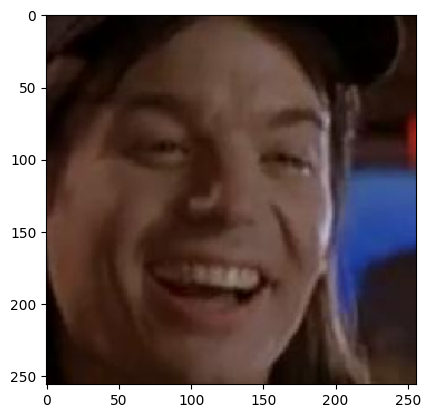

In [ ]:
# Rendering image X with label y for MesoNet
X, y = generator.next()

# Evaluating prediction
print(meso.predict(X)[0][0])
print(f"Predicted likelihood: {meso.predict(X)[0][0]:.4f}")
print(f"Actual label: {int(y[0])}")
print(f"\nCorrect prediction: {round(meso.predict(X)[0][0])==y[0]}")

# Showing image
plt.imshow(np.squeeze(X));
# print(y)

In [ ]:
# Creating separate lists for correctly classified and misclassified images
correct_real = []
correct_real_pred = []

correct_deepfake = []
correct_deepfake_pred = []

misclassified_real = []
misclassified_real_pred = []

misclassified_deepfake = []
misclassified_deepfake_pred = []

In [ ]:
# Generating predictions on validation set, storing in separate lists
# '''
for i in range(len(generator.labels)):
    
    # Loading next picture, generating prediction
    X, y = generator.next()
    pred = meso.predict(X)[0][0]
    
    # Sorting into proper category
    if round(pred)==y[0] and y[0]==1:
        correct_real.append(X)
        correct_real_pred.append(pred)
    elif round(pred)==y[0] and y[0]==0:
        correct_deepfake.append(X)
        correct_deepfake_pred.append(pred)
    elif y[0]==1:
        misclassified_real.append(X)
        misclassified_real_pred.append(pred)
    else:
        misclassified_deepfake.append(X)
        misclassified_deepfake_pred.append(pred)   
    val_loss, val_accuracy = meso.get_accuracy(val_x, val_y)
    print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}")

        
    # Printing status update
    if i % 1000 == 0:
        print(i, ' predictions completed.')
    
    if i == len(generator.labels)-1:
        print("All", len(generator.labels), "predictions completed")

# '''



1/1 [==============================] - 0s 31ms/step
Validation Loss: 0.0637, Validation Accuracy: 1.0000
0  predictions completed.
1/1 [==============================] - 0s 28ms/step
Validation Loss: 0.0637, Validation Accuracy: 1.0000
1/1 [==============================] - 0s 30ms/step
Validation Loss: 0.0637, Validation Accuracy: 1.0000
1/1 [==============================] - 0s 30ms/step
Validation Loss: 0.0637, Validation Accuracy: 1.0000
1/1 [==============================] - 0s 32ms/step
Validation Loss: 0.0637, Validation Accuracy: 1.0000
1/1 [==============================] - 0s 34ms/step
Validation Loss: 0.0637, Validation Accuracy: 1.0000
1/1 [==============================] - 0s 34ms/step
Validation Loss: 0.0637, Validation Accuracy: 1.0000
1/1 [==============================] - 0s 38ms/step
Validation Loss: 0.0637, Validation Accuracy: 1.0000
1/1 [==============================] - 0s 34ms/step
Validation Loss: 0.0637, Validation Accuracy: 1.0000
1/1 [========================

In [ ]:
def plotter(images,preds):
    fig = plt.figure(figsize=(16,9))
    subset = np.random.randint(0, len(images)-1, 4)
    for i,j in enumerate(subset):
        fig.add_subplot(3,4,i+1)
        plt.imshow(np.squeeze(images[j]))
        plt.xlabel(f"Model confidence: \n{preds[j]:.4f}")
        plt.tight_layout()
        ax = plt.gca()
        ax.axes.xaxis.set_ticks([])
        ax.axes.yaxis.set_ticks([])
    plt.show;
    return

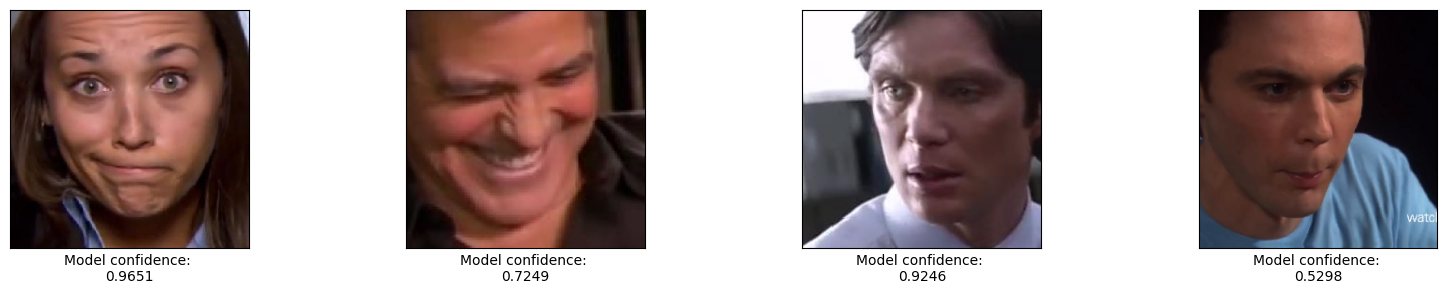

In [ ]:
# plotter(correct_real, correct_real_pred)

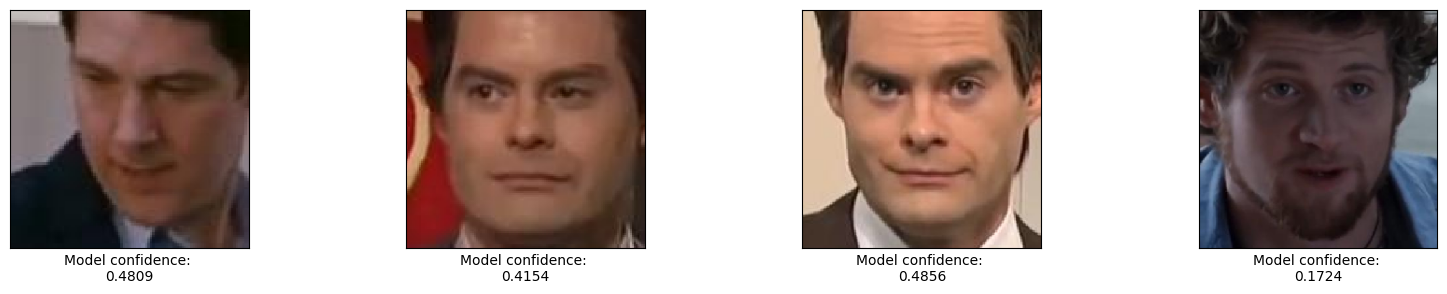

In [ ]:
# plotter(misclassified_real, misclassified_real_pred)

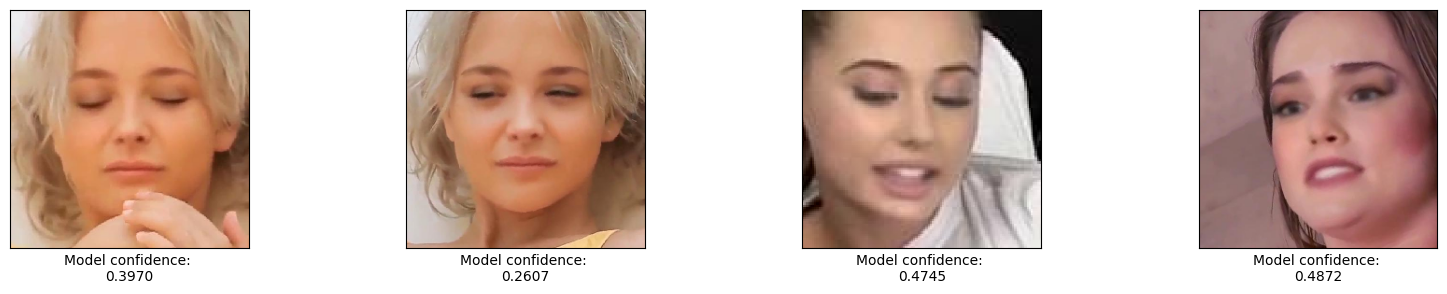

In [ ]:
# plotter(correct_deepfake, correct_deepfake_pred)

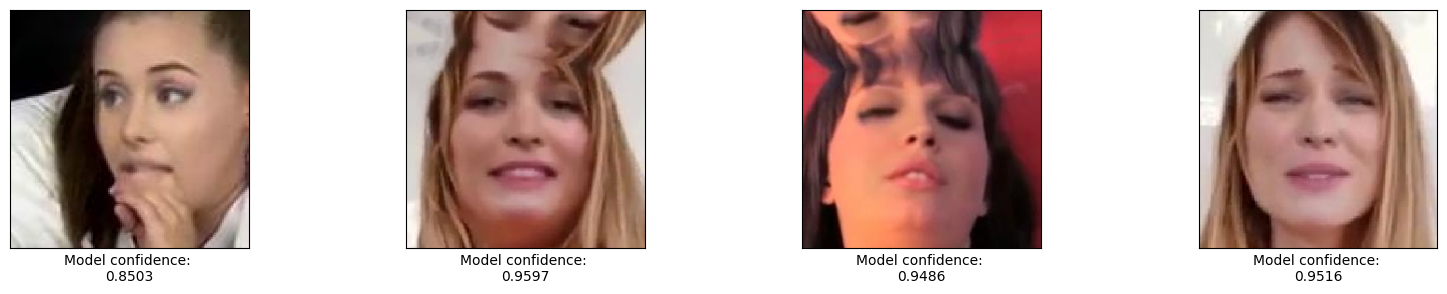

In [ ]:
# plotter(misclassified_deepfake, misclassified_deepfake_pred)

1/1 [==============================] - 0s 100ms/step
Predicted value: 0.3142
Image is :   Fake


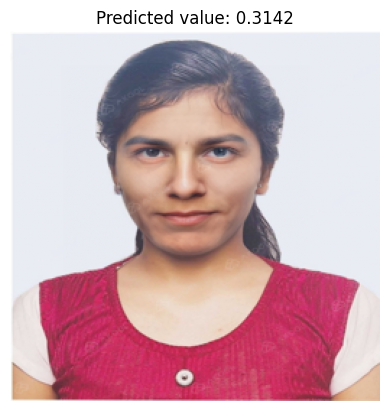

In [ ]:


from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model

image_path = './fakei1.jpg'
    

img = Image.open(image_path)
# Resize the image to match the input shape expected by the model
img = img.resize((256, 256))

# Convert the image to a numpy array and scale pixel values
img_array = np.array(img) / 255.0

# Add an extra dimension to match the model's input shape (1, 256, 256, 3)
img_array = np.expand_dims(img_array, axis=0)

# Predict the label for the single image
prediction = meso.predict(img_array)
# prediction = 1-prediction

# Access the prediction value
predicted_value = prediction[0][0]
print(f"Predicted value: {predicted_value:.4f}")
print(f'Image is :   {"Fake" if round(predicted_value) < 0.5 else "Real"}')
            
# Display the image with its prediction
plt.imshow(np.squeeze(img_array))
plt.title(f"Predicted value: {predicted_value:.4f}")
plt.axis('off')  # Hide the axis
plt.show()


1/1 [==============================] - 0s 95ms/step
Predicted value: 0.3738
Image is :   Fake


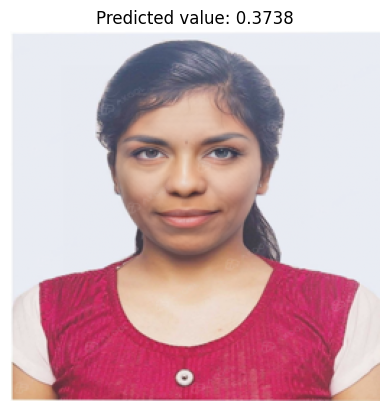

In [ ]:


from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model

image_path = './fakei2.jpg'
    

img = Image.open(image_path)
# Resize the image to match the input shape expected by the model
img = img.resize((256, 256))

# Convert the image to a numpy array and scale pixel values
img_array = np.array(img) / 255.0

# Add an extra dimension to match the model's input shape (1, 256, 256, 3)
img_array = np.expand_dims(img_array, axis=0)

# Predict the label for the single image
prediction = meso.predict(img_array)
# prediction = 1-prediction

# Access the prediction value
predicted_value = prediction[0][0]
print(f"Predicted value: {predicted_value:.4f}")
print(f'Image is :   {"Fake" if round(predicted_value) < 0.5 else "Real"}')

# Display the image with its prediction
plt.imshow(np.squeeze(img_array))
plt.title(f"Predicted value: {predicted_value:.4f}")
plt.axis('off')  # Hide the axis
plt.show()


1/1 [==============================] - 0s 108ms/step
Predicted value: 0.5809
Image is :   Real


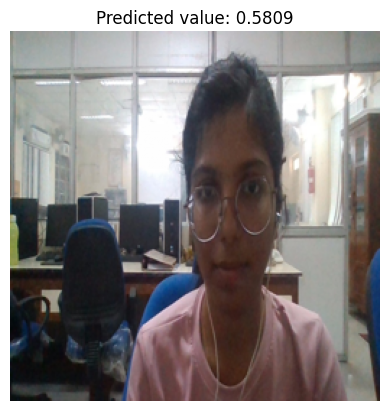

In [ ]:


from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model

image_path = './reali1.jpg'
    

img = Image.open(image_path)
# Resize the image to match the input shape expected by the model
img = img.resize((256, 256))

# Convert the image to a numpy array and scale pixel values
img_array = np.array(img) / 255.0

# Add an extra dimension to match the model's input shape (1, 256, 256, 3)
img_array = np.expand_dims(img_array, axis=0)

# Predict the label for the single image
prediction = meso.predict(img_array)
# prediction = 1-prediction

# Access the prediction value
predicted_value = prediction[0][0]
print(f"Predicted value: {predicted_value:.4f}")
print(f'Image is :   {"Fake" if round(predicted_value) < 0.5 else "Real"}')

# Display the image with its prediction
plt.imshow(np.squeeze(img_array))
plt.title(f"Predicted value: {predicted_value:.4f}")
plt.axis('off')  # Hide the axis
plt.show()


1/1 [==============================] - 0s 96ms/step
Predicted value: 0.9670
Image is :   Real


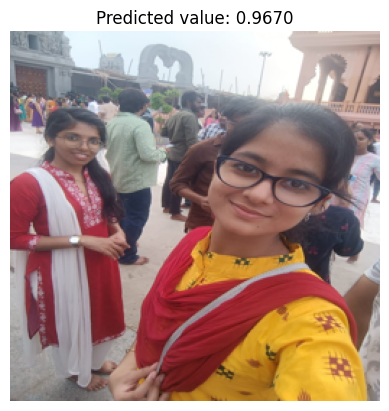

In [ ]:


from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model

image_path = './reali3.jpeg'
    

img = Image.open(image_path)
# Resize the image to match the input shape expected by the model
img = img.resize((256, 256))

# Convert the image to a numpy array and scale pixel values
img_array = np.array(img) / 255.0

# Add an extra dimension to match the model's input shape (1, 256, 256, 3)
img_array = np.expand_dims(img_array, axis=0)

# Predict the label for the single image
prediction = meso.predict(img_array)
# prediction = 1-prediction

# Access the prediction value
predicted_value = prediction[0][0]
print(f"Predicted value: {predicted_value:.4f}")
print(f'Image is :   {"Fake" if round(predicted_value) < 0.5 else "Real"}')


# Display the image with its prediction
plt.imshow(np.squeeze(img_array))
plt.title(f"Predicted value: {predicted_value:.4f}")
plt.axis('off')  # Hide the axis
plt.show()


1/1 [==============================] - 0s 121ms/step
Predicted value: 0.5809
Image is :   Real


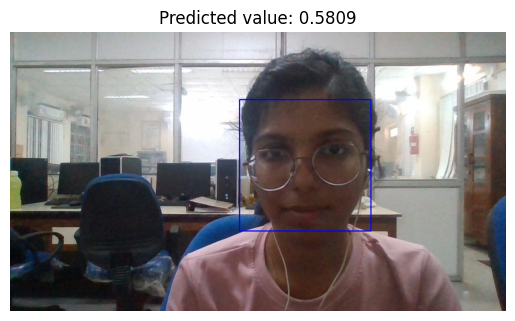

In [ ]:
import cv2
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model

# Load the pre-trained Haar Cascade Classifier for face detection
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

image_path = './reali1.jpg'

img = Image.open(image_path)
imgg = cv2.imread(image_path)
gray = cv2.cvtColor(imgg, cv2.COLOR_BGR2GRAY)

faces = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))
if len(faces) > 0:
    img = img.resize((256, 256))
    img_array = np.array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)
    
    prediction = meso.predict(img_array)
    predicted_value = prediction[0][0]
    print(f"Predicted value: {predicted_value:.4f}")
    print(f'Image is :   {"Fake" if round(predicted_value) < 0.5 else "Real"}')
    for (x, y, w, h) in faces:
        cv2.rectangle(imgg, (x, y), (x + w, y + h), (255, 0, 0), 2)
    imgg_rgb = cv2.cvtColor(imgg, cv2.COLOR_BGR2RGB)
    plt.imshow(imgg_rgb)
    plt.title(f"Predicted value: {predicted_value:.4f}")
    plt.axis('off') 
    plt.show()
else:
    print("face not found")

1/1 [==============================] - 0s 113ms/step
Predicted value: 0.3762
Image is :   Fake


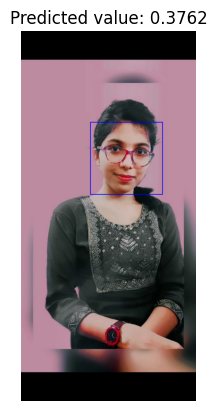

In [ ]:
import cv2
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model

# Load the pre-trained Haar Cascade Classifier for face detection
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

image_path = './reali2.jpg'

img = Image.open(image_path)
imgg = cv2.imread(image_path)
gray = cv2.cvtColor(imgg, cv2.COLOR_BGR2GRAY)

faces = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))
if len(faces) > 0:
    img = img.resize((256, 256))
    img_array = np.array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)
    
    prediction = meso.predict(img_array)
    predicted_value = prediction[0][0]
    print(f"Predicted value: {predicted_value:.4f}")
    print(f'Image is :   {"Fake" if round(predicted_value) < 0.5 else "Real"}')
    for (x, y, w, h) in faces:
        cv2.rectangle(imgg, (x, y), (x + w, y + h), (255, 0, 0), 2)
    imgg_rgb = cv2.cvtColor(imgg, cv2.COLOR_BGR2RGB)
    plt.imshow(imgg_rgb)
    plt.title(f"Predicted value: {predicted_value:.4f}")
    plt.axis('off') 
    plt.show()
else:
    print("face not found")

1/1 [==============================] - 0s 105ms/step
Predicted value: 0.9670
Image is :   Real


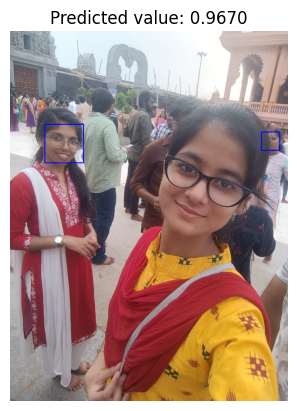

In [ ]:
import cv2
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model

# Load the pre-trained Haar Cascade Classifier for face detection
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

image_path = './reali3.jpeg'

img = Image.open(image_path)
imgg = cv2.imread(image_path)
gray = cv2.cvtColor(imgg, cv2.COLOR_BGR2GRAY)

faces = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))
if len(faces) > 0:
    img = img.resize((256, 256))
    img_array = np.array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)
    
    prediction = meso.predict(img_array)
    predicted_value = prediction[0][0]
    print(f"Predicted value: {predicted_value:.4f}")
    print(f'Image is :   {"Fake" if round(predicted_value) < 0.5 else "Real"}')
    for (x, y, w, h) in faces:
        cv2.rectangle(imgg, (x, y), (x + w, y + h), (255, 0, 0), 2)
    imgg_rgb = cv2.cvtColor(imgg, cv2.COLOR_BGR2RGB)
    plt.imshow(imgg_rgb)
    plt.title(f"Predicted value: {predicted_value:.4f}")
    plt.axis('off') 
    plt.show()
else:
    print("face not found")


1/1 [==============================] - 0s 109ms/step
Predicted value: 0.9335
Image is :   Real


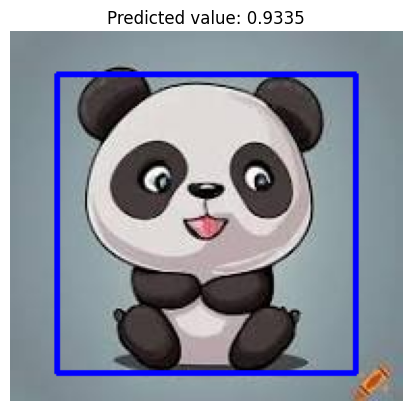

In [ ]:
import cv2
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model

# Load the pre-trained Haar Cascade Classifier for face detection
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

image_path = './cartoon.jpg'

img = Image.open(image_path)
imgg = cv2.imread(image_path)
gray = cv2.cvtColor(imgg, cv2.COLOR_BGR2GRAY)

faces = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))
if len(faces) > 0:
    img = img.resize((256, 256))
    img_array = np.array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)
    
    prediction = meso.predict(img_array)
    predicted_value = prediction[0][0]
    print(f"Predicted value: {predicted_value:.4f}")
    print(f'Image is :   {"Fake" if round(predicted_value) < 0.5 else "Real"}')
    for (x, y, w, h) in faces:
        cv2.rectangle(imgg, (x, y), (x + w, y + h), (255, 0, 0), 2)
    imgg_rgb = cv2.cvtColor(imgg, cv2.COLOR_BGR2RGB)
    plt.imshow(imgg_rgb)
    plt.title(f"Predicted value: {predicted_value:.4f}")
    plt.axis('off') 
    plt.show()
else:
    print("face not found")



In [ ]:

import cv2

cap = cv2.VideoCapture('./fakev3.mp4')
frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
print(frame_count)
real_count = 0
fake_count = 0

while cap.isOpened():
    for i in range (frame_count):
        ret, frame = cap.read()
       
        if ret:
            frame = cv2.resize(frame,(256,256))
            # frame = frame.astype('float32') / 255.0 
            frame_array = np.array(frame) / 255.0
            frame_array = np.expand_dims(frame_array, axis=0)
            prediction = meso.predict(frame_array)
            predicted_value = prediction[0][0]
            print(f"Predicted value: {predicted_value:.4f}")


            # img = Image.open(image_path)
            # img = img.resize((256, 256))
            # img_array = np.array(img) / 255.0
            # img_array = np.expand_dims(img_array, axis=0)
            # prediction = meso.predict(img_array)
            # predicted_value = prediction[0][0]
            # print(f"Predicted value: {predicted_value:.4f}")

            if round(predicted_value) < 0.5:
                fake_count = fake_count + 1
            else:
                real_count = real_count + 1
                
            print(f'Frame: {cap.get(cv2.CAP_PROP_POS_FRAMES)}, Prediction: {"Fake" if round(predicted_value) < 0.5 else "Real"}, Confidence: {predicted_value:.4f}')
            
    break
cap.release()
cv2.destroyAllWindows()

# Summary of predictions
total_frames = real_count + fake_count

print(f'Total frames: {total_frames}')
print(f'Real frames: {real_count} ({(real_count / total_frames) * 100:.2f}%)')
print(f'Fake frames: {fake_count} ({(fake_count / total_frames) * 100:.2f}%)')

# Determine overall video prediction
if fake_count > real_count:
    print('The video is predicted to be a Deepfake.')
else:
    print('The video is predicted to be Real.')



234
1/1 [==============================] - 0s 106ms/step
Predicted value: 0.9260
Frame: 1.0, Prediction: Real, Confidence: 0.9260
1/1 [==============================] - 0s 109ms/step
Predicted value: 0.8554
Frame: 2.0, Prediction: Real, Confidence: 0.8554
1/1 [==============================] - 0s 109ms/step
Predicted value: 0.9111
Frame: 3.0, Prediction: Real, Confidence: 0.9111
1/1 [==============================] - 0s 116ms/step
Predicted value: 0.9090
Frame: 4.0, Prediction: Real, Confidence: 0.9090
1/1 [==============================] - 0s 119ms/step
Predicted value: 0.9563
Frame: 5.0, Prediction: Real, Confidence: 0.9563
1/1 [==============================] - 0s 126ms/step
Predicted value: 0.9706
Frame: 6.0, Prediction: Real, Confidence: 0.9706
1/1 [==============================] - 0s 111ms/step
Predicted value: 0.9726
Frame: 7.0, Prediction: Real, Confidence: 0.9726
1/1 [==============================] - 0s 103ms/step
Predicted value: 0.9251
Frame: 8.0, Prediction: Real, Confide

In [ ]:

import cv2
import numpy as np
cap = cv2.VideoCapture('./fakev4.mp4')
frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
print(frame_count)
real_count = 0
fake_count = 0

while cap.isOpened():
    for i in range (frame_count):
        ret, frame = cap.read()
       
        if ret:
            frame = cv2.resize(frame,(256,256))
            # frame = np.array(frame) / 255.0
            frame = frame.astype('float32') / 255.0  # Normalize the frame
            frame = np.expand_dims(frame, axis=0)
            prediction = meso.predict(frame)[0][0]
            # prediction= 1-prediction
            print(f"Predicted value: {prediction:.4f}")

            if round(prediction) < 0.5:
                fake_count = fake_count + 1
            else:
                real_count = real_count + 1
                
            print(f'Frame: {cap.get(cv2.CAP_PROP_POS_FRAMES)}, Prediction: {"Fake" if round(prediction) < 0.5 else "Real"}, Confidence: {prediction:.4f}')
            
    break
cap.release()
cv2.destroyAllWindows()

# Summary of predictions
total_frames = real_count + fake_count

print(f'Total frames: {total_frames}')
print(f'Real frames: {real_count} ({(real_count / total_frames) * 100:.2f}%)')
print(f'Fake frames: {fake_count} ({(fake_count / total_frames) * 100:.2f}%)')

# Determine overall video prediction
if fake_count > real_count:
    print('The video is predicted to be a Deepfake.')
else:
    print('The video is predicted to be Real.')



303
1/1 [==============================] - 0s 147ms/step
Predicted value: 0.6211
Frame: 1.0, Prediction: Real, Confidence: 0.6211
1/1 [==============================] - 0s 112ms/step
Predicted value: 0.6027
Frame: 2.0, Prediction: Real, Confidence: 0.6027
1/1 [==============================] - 0s 125ms/step
Predicted value: 0.7110
Frame: 3.0, Prediction: Real, Confidence: 0.7110
1/1 [==============================] - 0s 129ms/step
Predicted value: 0.7104
Frame: 4.0, Prediction: Real, Confidence: 0.7104
1/1 [==============================] - 0s 106ms/step
Predicted value: 0.6838
Frame: 5.0, Prediction: Real, Confidence: 0.6838
1/1 [==============================] - 0s 116ms/step
Predicted value: 0.6250
Frame: 6.0, Prediction: Real, Confidence: 0.6250
1/1 [==============================] - 0s 115ms/step
Predicted value: 0.6855
Frame: 7.0, Prediction: Real, Confidence: 0.6855
1/1 [==============================] - 0s 117ms/step
Predicted value: 0.5670
Frame: 8.0, Prediction: Real, Confide

In [ ]:

import cv2
import numpy as np

def predict_frame(frame):
    frame = cv2.resize(frame,(256,256))
    frame = np.array(frame) / 255.0
    # frame = frame.astype('float32') / 255.0  # Normalize the frame
    frame = np.expand_dims(frame, axis=0)
    prediction = meso.predict(frame)[0][0]
    return prediction

# './Testvideo.mp4'
cap = cv2.VideoCapture('./fakevv3.mp4')
frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
print(frame_count)
real_count = 0
fake_count = 0

while cap.isOpened():
    ret, frame = cap.read()
    # if not ret:
    #     print("Hiiii")
    #     break
    if ret:    
        prediction = predict_frame(frame)
            
        if prediction > 0.5:
            real_count = real_count + 1
        else:
            fake_count = fake_count + 1
            
        print(f'Frame: {cap.get(cv2.CAP_PROP_POS_FRAMES)}, Prediction: {"Real" if prediction > 0.5 else "Fake"}, Confidence: {prediction:.4f}')
        if (cv2.waitKey(1) & 0xff==ord('m')):
            break
    cap.release()
    cv2.waitKey(5000)
    cv2.destroyAllWindows()
print(real_count)
print(fake_count)
# Summary of predictions
# total_frames = real_count + fake_count
# real_percentage = (real_count / total_frames) * 100
# fake_percentage = (fake_count / total_frames) * 100

# print(f'Total frames: {total_frames}')
# print(f'Real frames: {real_count} ({real_percentage:.2f}%)')
# print(f'Fake frames: {fake_count} ({fake_percentage:.2f}%)')

# Determine overall video prediction
if fake_count > real_count:
    print('The video is predicted to be a Deepfake.')
else:
    print('The video is predicted to be Real.')



0
0
0
The video is predicted to be Real.


In [ ]:

import cv2
import numpy as np

def predict_frame(frame):
    frame = cv2.resize(frame,(256,256))
    frame = np.array(frame) / 255.0
    # frame = frame.astype('float32') / 255.0  # Normalize the frame
    frame = np.expand_dims(frame, axis=0)
    prediction = meso.predict(frame)[0][0]
    return prediction

# './Testvideo.mp4'
cap = cv2.VideoCapture('./j.gif')
frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
print(frame_count)
real_count = 0
fake_count = 0

while cap.isOpened():
    ret, frame = cap.read()
    # if not ret:
    #     print("Hiiii")
    #     break
    if ret:    
        prediction = predict_frame(frame)
            
        if prediction > 0.5:
            real_count = real_count + 1
        else:
            fake_count = fake_count + 1
            
        print(f'Frame: {cap.get(cv2.CAP_PROP_POS_FRAMES)}, Prediction: {"Real" if prediction > 0.5 else "Fake"}, Confidence: {prediction:.4f}')
        if (cv2.waitKey(1) & 0xff==ord('m')):
            break
    cap.release()
    cv2.waitKey(5000)
    cv2.destroyAllWindows()
print(real_count)
print(fake_count)
# Summary of predictions
# total_frames = real_count + fake_count
# real_percentage = (real_count / total_frames) * 100
# fake_percentage = (fake_count / total_frames) * 100

# print(f'Total frames: {total_frames}')
# print(f'Real frames: {real_count} ({real_percentage:.2f}%)')
# print(f'Fake frames: {fake_count} ({fake_percentage:.2f}%)')

# Determine overall video prediction
if fake_count > real_count:
    print('The video is predicted to be a Deepfake.')
else:
    print('The video is predicted to be Real.')



67
1/1 [==============================] - 0s 110ms/step
Frame: 1.0, Prediction: Real, Confidence: 0.5305
1
0
The video is predicted to be Real.


In [ ]:

import cv2
import numpy as np
cap = cv2.VideoCapture('./fakev1.mp4')
frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
print(frame_count)
real_count = 0
fake_count = 0

while cap.isOpened():
    for i in range (frame_count):
        ret, frame = cap.read()
       
        if ret:
            frame = cv2.resize(frame,(256,256))
            # frame = np.array(frame) / 255.0
            frame = frame.astype('float32') / 255.0  # Normalize the frame
            frame = np.expand_dims(frame, axis=0)
            prediction = meso.predict(frame)[0][0]
            # prediction= 1-prediction
            print(f"Predicted value: {prediction:.4f}")

            if round(prediction) < 0.5:
                fake_count = fake_count + 1
            else:
                real_count = real_count + 1
                
            print(f'Frame: {cap.get(cv2.CAP_PROP_POS_FRAMES)}, Prediction: {"Fake" if round(prediction) < 0.5 else "Real"}, Confidence: {prediction:.4f}')
            
    break
cap.release()
cv2.destroyAllWindows()

# Summary of predictions
total_frames = real_count + fake_count

print(f'Total frames: {total_frames}')
print(f'Real frames: {real_count} ({(real_count / total_frames) * 100:.2f}%)')
print(f'Fake frames: {fake_count} ({(fake_count / total_frames) * 100:.2f}%)')

# Determine overall video prediction
if fake_count > real_count:
    print('The video is predicted to be a Deepfake.')
else:
    print('The video is predicted to be Real.')



234
1/1 [==============================] - 0s 131ms/step
Predicted value: 0.9710
Frame: 1.0, Prediction: Real, Confidence: 0.9710
1/1 [==============================] - 0s 126ms/step
Predicted value: 0.9561
Frame: 2.0, Prediction: Real, Confidence: 0.9561
1/1 [==============================] - 0s 117ms/step
Predicted value: 0.9607
Frame: 3.0, Prediction: Real, Confidence: 0.9607
1/1 [==============================] - 0s 120ms/step
Predicted value: 0.9555
Frame: 4.0, Prediction: Real, Confidence: 0.9555
1/1 [==============================] - 0s 116ms/step
Predicted value: 0.9625
Frame: 5.0, Prediction: Real, Confidence: 0.9625
1/1 [==============================] - 0s 107ms/step
Predicted value: 0.9686
Frame: 6.0, Prediction: Real, Confidence: 0.9686
1/1 [==============================] - 0s 114ms/step
Predicted value: 0.9691
Frame: 7.0, Prediction: Real, Confidence: 0.9691
1/1 [==============================] - 0s 101ms/step
Predicted value: 0.9555
Frame: 8.0, Prediction: Real, Confide

In [ ]:

import cv2
import numpy as np
cap = cv2.VideoCapture('./fakev2.mp4')
frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
print(frame_count)
real_count = 0
fake_count = 0

while cap.isOpened():
    for i in range (frame_count):
        ret, frame = cap.read()
       
        if ret:
            frame = cv2.resize(frame,(256,256))
            # frame = np.array(frame) / 255.0
            frame = frame.astype('float32') / 255.0  # Normalize the frame
            frame = np.expand_dims(frame, axis=0)
            prediction = meso.predict(frame)[0][0]
            # prediction= 1-prediction
            print(f"Predicted value: {prediction:.4f}")

            if round(prediction) < 0.5:
                fake_count = fake_count + 1
            else:
                real_count = real_count + 1
                
            print(f'Frame: {cap.get(cv2.CAP_PROP_POS_FRAMES)}, Prediction: {"Fake" if round(prediction) < 0.5 else "Real"}, Confidence: {prediction:.4f}')
            
    break
cap.release()
cv2.destroyAllWindows()

# Summary of predictions
total_frames = real_count + fake_count

print(f'Total frames: {total_frames}')
print(f'Real frames: {real_count} ({(real_count / total_frames) * 100:.2f}%)')
print(f'Fake frames: {fake_count} ({(fake_count / total_frames) * 100:.2f}%)')

# Determine overall video prediction
if fake_count > real_count:
    print('The video is predicted to be a Deepfake.')
else:
    print('The video is predicted to be Real.')



234
1/1 [==============================] - 0s 117ms/step
Predicted value: 0.9710
Frame: 1.0, Prediction: Real, Confidence: 0.9710
1/1 [==============================] - 0s 110ms/step
Predicted value: 0.9561
Frame: 2.0, Prediction: Real, Confidence: 0.9561
1/1 [==============================] - 0s 101ms/step
Predicted value: 0.9607
Frame: 3.0, Prediction: Real, Confidence: 0.9607
1/1 [==============================] - 0s 108ms/step
Predicted value: 0.9555
Frame: 4.0, Prediction: Real, Confidence: 0.9555
1/1 [==============================] - 0s 106ms/step
Predicted value: 0.9625
Frame: 5.0, Prediction: Real, Confidence: 0.9625
1/1 [==============================] - 0s 113ms/step
Predicted value: 0.9686
Frame: 6.0, Prediction: Real, Confidence: 0.9686
1/1 [==============================] - 0s 113ms/step
Predicted value: 0.9691
Frame: 7.0, Prediction: Real, Confidence: 0.9691
1/1 [==============================] - 0s 110ms/step
Predicted value: 0.9555
Frame: 8.0, Prediction: Real, Confide

In [ ]:

import cv2
import numpy as np
cap = cv2.VideoCapture('./realv1.mp4')
frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
print(frame_count)
real_count = 0
fake_count = 0

while cap.isOpened():
    for i in range (frame_count):
        ret, frame = cap.read()
       
        if ret:
            frame = cv2.resize(frame,(256,256))
            # frame = np.array(frame) / 255.0
            frame = frame.astype('float32') / 255.0  # Normalize the frame
            frame = np.expand_dims(frame, axis=0)
            prediction = meso.predict(frame)[0][0]
            # prediction= 1-prediction
            print(f"Predicted value: {prediction:.4f}")

            if round(prediction) < 0.5:
                fake_count = fake_count + 1
            else:
                real_count = real_count + 1
                
            print(f'Frame: {cap.get(cv2.CAP_PROP_POS_FRAMES)}, Prediction: {"Fake" if round(prediction) < 0.5 else "Real"}, Confidence: {prediction:.4f}')
            
    break
cap.release()
cv2.destroyAllWindows()

# Summary of predictions
total_frames = real_count + fake_count

print(f'Total frames: {total_frames}')
print(f'Real frames: {real_count} ({(real_count / total_frames) * 100:.2f}%)')
print(f'Fake frames: {fake_count} ({(fake_count / total_frames) * 100:.2f}%)')

# Determine overall video prediction
if fake_count > real_count:
    print('The video is predicted to be a Deepfake.')
else:
    print('The video is predicted to be Real.')



234
1/1 [==============================] - 0s 107ms/step
Predicted value: 0.9608
Frame: 1.0, Prediction: Real, Confidence: 0.9608
1/1 [==============================] - 0s 105ms/step
Predicted value: 0.9190
Frame: 2.0, Prediction: Real, Confidence: 0.9190
1/1 [==============================] - 0s 115ms/step
Predicted value: 0.9552
Frame: 3.0, Prediction: Real, Confidence: 0.9552
1/1 [==============================] - 0s 115ms/step
Predicted value: 0.9637
Frame: 4.0, Prediction: Real, Confidence: 0.9637
1/1 [==============================] - 0s 116ms/step
Predicted value: 0.9694
Frame: 5.0, Prediction: Real, Confidence: 0.9694
1/1 [==============================] - 0s 114ms/step
Predicted value: 0.9671
Frame: 6.0, Prediction: Real, Confidence: 0.9671
1/1 [==============================] - 0s 105ms/step
Predicted value: 0.9567
Frame: 7.0, Prediction: Real, Confidence: 0.9567
1/1 [==============================] - 0s 118ms/step
Predicted value: 0.9323
Frame: 8.0, Prediction: Real, Confide